In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

## Step 1: Data Cleaning

### Loading the raw data

In [ ]:
raw_data = pd.read_csv('../input/used-cars-price/Used Car Price.csv')
raw_data.head()

In [ ]:
raw_data.describe(include='all')

### Determining the variables of interest

In [ ]:
data = raw_data.drop(['Model'],axis=1)
data.describe(include='all')

### Dealing with missing values

In [ ]:
data.isnull().sum()

In [ ]:
data_no_mv = data.dropna(axis=0)

In [ ]:
data_no_mv.describe(include='all')

### Exploring the PDFs

In [ ]:
sns.kdeplot(data_no_mv['Price'], shade = True)

### Dealing with outliers

In [ ]:
q = data_no_mv['Price'].quantile(0.99)
data_1 = data_no_mv[data_no_mv['Price']<q]
data_1.describe(include='all')

In [ ]:
sns.kdeplot(data_1['Price'], shade = True)

In [ ]:
sns.kdeplot(data_no_mv['Mileage'], shade = True)

In [ ]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]

In [ ]:
sns.kdeplot(data_2['Mileage'], shade = True)

In [ ]:
sns.kdeplot(data_no_mv['EngineV'], shade = True)

In [ ]:
data_3 = data_2[data_2['EngineV']<6.5]

In [ ]:
sns.kdeplot(data_3['EngineV'], shade = True)

In [ ]:
sns.kdeplot(data_no_mv['Year'], shade = True)

In [ ]:
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]

In [ ]:
sns.kdeplot(data_4['Year'], shade = True)

In [ ]:
data_cleaned = data_4.reset_index(drop=True)

In [ ]:
data_cleaned.describe(include='all')

## Step 2: Checking the Regression Assumptions
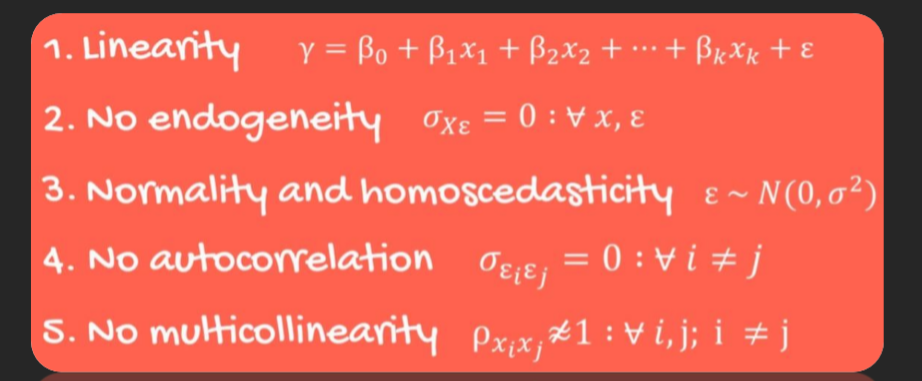

### 1- Linearity

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))

ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')

ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')

ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

In [ ]:
log_price = np.log(data_cleaned['Price'])
data_cleaned['log_price'] = log_price
data_cleaned

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize =(15,3))

ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')

ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')

ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')


plt.show()

In [ ]:
data_cleaned_2 = data_cleaned.drop(['Price'],axis=1)

### 2- No Endogeneity
We will talk about this issue later.

KeyWords: Hausman test, IV, 2SLS, GMM, ...

See the following link:

A good example: https://python.quantecon.org/ols.html#Endogeneity

How we can intrpret our results: https://stats.stackexchange.com/questions/210696/how-to-interpret-hausman-test-results

Documentations of linearmodels library: https://bashtage.github.io/linearmodels/doc/iv/introduction.html

### 3- Normality and Homoscedasticity
Just check the above graphs. Since intercept has been included in our model, so the mean of error is ZERO.

### 4- No Autocorrelation
We should not be worry, because our data is not a time series data or a panel data.

### 5- No Multicollinearity
VIF (Variance Inflation Factor) and its application in detecting Multicollinearity
If VIF > 10, then multicollinearity is high and we should remove that item.

In [ ]:
data_cleaned_2.columns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data_cleaned_2[['Mileage','Year','EngineV']]

vif = pd.DataFrame()

vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif["features"] = variables.columns

In [ ]:
data_no_multicollinearity = data_cleaned_2.drop(['Year'],axis=1)

## Step 3: Create dummy Variables¶
In session 14 we create a dummy variable by using map

data = raw_data.copy()

data['Attendance'] = data['Attendance'].map({'Yes': 1, 'No': 0})

#### Now in what follows, we will create dummies by a simple code of Pandas

#### Note that if we have N categories for a feature, we have to create N-1 dummies
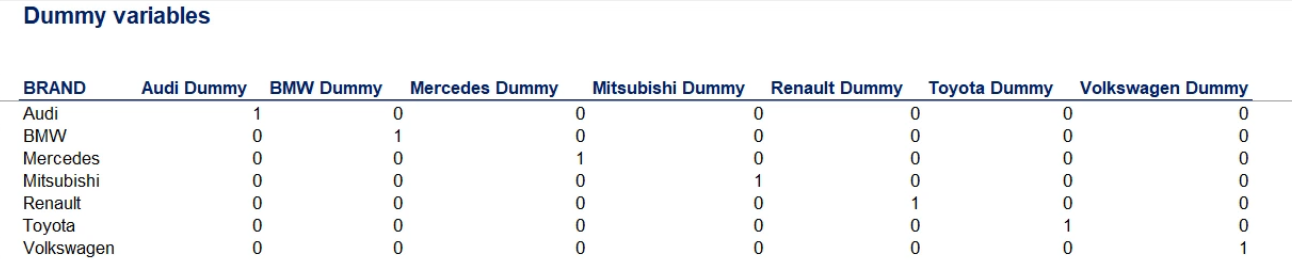

In [ ]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first = True)

data_with_dummies

In [ ]:
data_with_dummies.columns.values

In [ ]:
# Now we create a list of our desired columns order as follows:

new_columns = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

In [ ]:
data_preprocessed = data_with_dummies[new_columns]
data_preprocessed

## Step 4: Creating the Linear Regression Model

In [ ]:
targets = data_preprocessed['log_price']

inputs = data_preprocessed.drop(['log_price'],axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(inputs)

inputs_scaled = scaler.transform(inputs)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=42)

In [ ]:
reg = LinearRegression()

reg.fit(x_train,y_train)

In [ ]:
y_hat = reg.predict(x_train)

In [ ]:
plt.scatter(y_train, y_hat)

plt.xlabel('Targets (y_train)',size=15)
plt.ylabel('Predictions (y_hat)',size=15)

plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

**Pay Attention Please:**

An ERROR is the difference between the observed value and the true value (very often unobserved, generated by the data generating process (DGP)). Consider the example of Height and Weight.

A RESIDUAL is the difference between the observed value and the predicted value (by the model).

In [ ]:
sns.kdeplot(y_train - y_hat, shade = True)
plt.title("Residuals PDF", size=15)

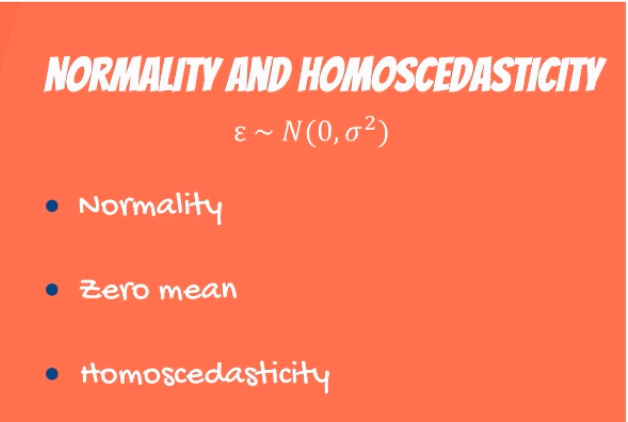

In [ ]:
reg.score(x_train,y_train)

**Note:**

The most common interpretation of r-squared is how well the regression model fits the observed data. For example, an r-squared of 0.60 reveals that 60% of the data fit the regression model. Generally, a higher r-squared indicates a better fit for the model.

In [ ]:
reg.intercept_

In [ ]:
reg.coef_

In [ ]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])

reg_summary['Weights'] = reg.coef_

reg_summary

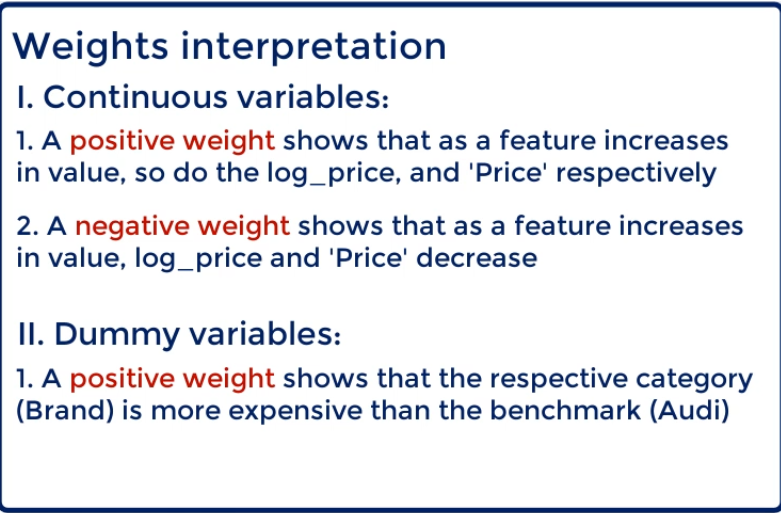

## Step 5: Testing our Model

In [ ]:
y_hat_test = reg.predict(x_test)

In [ ]:
plt.scatter(y_test, y_hat_test)

plt.xlabel('Targets (y_test)',size=15)
plt.ylabel('Predictions (y_hat_test)',size=15)

plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

Recall that we have:
1: $ln (e^x) =x$

2: $e^{ln(x)} = x$

So,

$e^{ln (Price)}= Price$

In [ ]:
df_performance = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])

df_performance.head()

In [ ]:
df_performance['Target'] = np.exp(y_test)

df_performance.head()

In [ ]:
y_test.head()

In [ ]:
y_test = y_test.reset_index(drop=True)
y_test.head()

In [ ]:
df_performance['Target'] = np.exp(y_test)
df_performance

Percent Error = $\Big|(Target-Prediction)\times \frac{100}{Target}\Big| = \frac{Residual}{Target}\times 100$

See the following link for more details:

https://www.mathsisfun.com/data/percentage-difference-vs-error.html

In [ ]:
df_performance['Residual'] = df_performance['Target'] - df_performance['Prediction']

df_performance['Percent Error'] = np.absolute(df_performance['Residual']/df_performance['Target']*100)

df_performance

In [ ]:
df_performance.describe()

In [ ]:
pd.options.display.max_rows = 999

df_performance.sort_values(by=['Percent Error'], inplace=True)

np.round(df_performance, 3)


You can change the values of Target to int:

df_performance['Target'] = df_performance['Target'].astype(int)

You can also use of this code to get a rounded two decimal float number:

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
np.round(reg_summary, 2)

Our Model

$\hat{y} = -0.47\times Mileage + 0.22\times EngineV + 0.01\times Brand\_BMW + \ldots + 0.31\times Registration\_yes$